1. Load required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly_calplot import calplot
%matplotlib inline

import time
import random
import calmap
import warnings
warnings.filterwarnings('ignore')


sns.set_theme(style="darkgrid")
current_palette = sns.color_palette()


In [2]:
pd.options.display.min_rows = 20
pd.options.display.max_columns = 500


### Load in the data

In [3]:
n= 40000000
s= 1000000
skip = sorted(random.sample(range(1,n),n-s))
df_flights = pd.read_csv("../../data/eda/flights/all_flight_data_20182022/all_flight_data_20182022.zip",skiprows=skip, low_memory=False)


In [4]:
df_flights = df_flights.rename(columns={"Operating_Airline ": "Operating_Airline", "Flight_Number_Operating_Airline": "Flight_Number"})

In [5]:
airlines = pd.read_csv(
    "../../data/databases/flight_attributes/airlines.csv.zip", low_memory=False)
airline_mapper = airlines.set_index("Code")["Description"]

In [6]:
cancellation_codes = pd.read_csv(
    "../../data/databases/flight_attributes/cancellation_codes.csv", low_memory=False)
cancellation_code_mapper = cancellation_codes.set_index(
    "CANCELLATION_REASON")["CANCELLATION_DESCRIPTION"]


In [7]:
usa_airports = (pd.read_csv("../../data/databases/flight_attributes/usa_airports.csv.zip",
                            usecols= ["iata","latitude","longitude"], 
                            low_memory=False))
usa_airports = usa_airports.rename(columns={"iata": "Origin"})



### Data Pre-processing Phase
- EDA
- Feature Engineering
  - Handling missing values
  - Encoding Categorical Variables
- Feature Selection 
- Statistical Analysis
- Train - Test Split

In [8]:
#df_flights.dtypes

In [9]:
def airline_mapping(df_flights):
    df_flights["Operating_Airline"] = (
        df_flights["Operating_Airline"].map(airline_mapper))
    df_flights["CancellationCode"] = (
        df_flights["CancellationCode"].map(cancellation_code_mapper))
    return df_flights

def tweak_df_flights(df_flights):
    SELECTED_COLUMNS = ["FlightDate", "Operating_Airline", "Tail_Number", "Flight_Number", "OriginAirportID",
                        "Origin", "OriginCityName", "OriginState", "OriginStateName", "DestAirportID", "Dest", "DestCityName",
                        "DestState", "DestStateName", "CRSDepTime", "DepTime", "DepDelay", "DepDel15", "DepDelayMinutes", "DepTimeBlk",
                        "TaxiOut", "WheelsOn", "TaxiIn", "CRSArrTime", "ArrTime", "ArrDelayMinutes", "ArrDel15", "ArrTimeBlk",
                        "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime", "AirTime", "Distance", "CarrierDelay",
                        "WeatherDelay", "NASDelay", "SecurityDelay", "LateAircraftDelay", "FirstDepTime", "TotalAddGTime",
                        ]
    df_flights = (
        df_flights[SELECTED_COLUMNS]
        .copy()
    )
    df_flights = (pd.merge(df_flights, usa_airports, how="left", on=["Origin"]))
    df_flights.pipe(airline_mapping)
    return df_flights.assign(
        DepTime=df_flights.DepTime.fillna(0).astype("float16"),
        DepDelay=df_flights.DepDelay.fillna(0).astype("float16"),
        DepDel15=df_flights.DepDel15.fillna(0).astype("float16"),
        DepDelayMinutes=df_flights.DepDelayMinutes.fillna(0).astype("float16"),
        TaxiOut=df_flights.TaxiOut.fillna(0).astype("float16"),
        WheelsOn=df_flights.WheelsOn.fillna(0).astype("float16"),
        TaxiIn=df_flights.TaxiIn.fillna(0).astype("float16"),
        ArrDel15=df_flights.ArrDel15.fillna(0).astype("float16"),
        ArrDelayMinutes=df_flights.ArrDelayMinutes.fillna(0).astype("float16"),
        CRSElapsedTime=df_flights.CRSElapsedTime.fillna(0).astype("float16"),
        ArrTime=df_flights.ArrTime.fillna(0).astype("float16"),
        AirTime=df_flights.AirTime.fillna(0).astype("float16"),
        Distance=df_flights.Distance.fillna(0).astype("float16"),
        CarrierDelay=df_flights.CarrierDelay.fillna(0).astype("float16"),
        WeatherDelay=df_flights.WeatherDelay.fillna(0).astype("float16"),
        NASDelay=df_flights.NASDelay.fillna(0).astype("float16"),
        SecurityDelay=df_flights.SecurityDelay.fillna(0).astype("float16"),
        LateAircraftDelay=df_flights.LateAircraftDelay.fillna(
            0).astype("float16"),
        FirstDepTime=df_flights.FirstDepTime.fillna(0).astype("float16"),
        TotalAddGTime=df_flights.TotalAddGTime.fillna(0).astype("float16"),
        CancellationCode=df_flights.CancellationCode.fillna(
            "none").astype("category"),
        Tail_Number=df_flights.Tail_Number.fillna("none").astype("category"),
        FlightDate=pd.to_datetime(df_flights.FlightDate)
    ).astype(
        {
            "Operating_Airline": "category",
            "Origin": "category",
            "Dest": "category",
            "DestState": "category",
            "OriginState": "category",
            "OriginCityName": "category",
            "OriginStateName": "category",
            "DestStateName": "category",
            "DestCityName": "category",
            "DepTimeBlk": "category",
            "ArrTimeBlk": "category",
            #"Cancelled": "bool",
            "Diverted": "bool",
            "OriginAirportID": "int16",
            "DestAirportID": "int16",
            "CRSDepTime": "int16",
            "CRSArrTime": "int16",
            "Flight_Number": "int16",
            "latitude": "float16",
            "longitude": "float16"
        }
    )


df_flights = tweak_df_flights(df_flights)

##########Flight Status Categories####################
###############DepDelayGroups#########################
# Departure Delay intervals until 180 mins
def DepDelay_Class(df_flights):
    df_flights["DepDelayClass"] = None
    df_flights.loc[df_flights["DepDelayMinutes"] <= 15, "DepDelayClass"] = "OnTime"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 15) & (df_flights["DepDelayMinutes"] <= 45), "DepDelayClass"] = "Delay15_45"
    df_flights.loc[(df_flights["DepDelayMinutes"] > 45), "DepDelayClass"] = "Delay45_180"
    df_flights.loc[(df_flights["Cancelled"] > 0), "DepDelayClass"] = "Cancelled"
    
DepDelay_Class(df_flights)
df_flights["DepDelayClass"].astype("category")

# Handling Ordinal Categorical Variables [Label Encoding]
# assign the feature with ranks [Ordinal numbering encoding (Label Encoding)]
# engineer categorical variable by ordinal number replacement
DepDelayClass_mapping = {
    'OnTime': '1',
    'Delay15_45': '2',
    'Delay45_180': '3',
    'Cancelled': '4',
    }

df_flights["DepDelayClass_ordinal"] = df_flights.DepDelayClass.map(DepDelayClass_mapping)


print(df_flights.shape)
df_flights.tail()


(745432, 45)


,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,DepDelayClass_ordinal
745427,2022-08-13,Comair Inc.,N511AE,5293,12217,HSV,"Huntsville, AL",AL,Alabama,11057,CLT,"Charlotte, NC",NC,North Carolina,1917,1904.0,-13.0,0.0,0.0,1900-1959,8.0,2112.0,14.0,2150,2124.0,0.0,0.0,2100-2159,0.0,none,False,93.0,59.0,333.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.62500,-86.7500,OnTime,1
745428,2022-08-27,Comair Inc.,N567NN,5293,12217,HSV,"Huntsville, AL",AL,Alabama,11057,CLT,"Charlotte, NC",NC,North Carolina,1914,1901.0,-13.0,0.0,0.0,1900-1959,12.0,2108.0,17.0,2150,2126.0,0.0,0.0,2100-2159,0.0,none,False,96.0,56.0,333.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.62500,-86.7500,OnTime,1
745429,2022-08-12,Comair Inc.,N571NN,5294,11278,DCA,"Washington, DC",VA,Virginia,12323,ILM,"Wilmington, NC",NC,North Carolina,837,833.0,-4.0,0.0,0.0,0800-0859,35.0,1004.0,3.0,958,1007.0,9.0,0.0,0900-0959,0.0,none,False,81.0,56.0,319.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625,OnTime,1
745430,2022-08-26,Comair Inc.,N603NN,5296,11278,DCA,"Washington, DC",VA,Virginia,11986,GRR,"Grand Rapids, MI",MI,Michigan,1712,1711.0,-1.0,0.0,0.0,1700-1759,22.0,1854.0,5.0,1906,1859.0,0.0,0.0,1900-1959,0.0,none,False,114.0,81.0,524.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.84375,-77.0625,OnTime,1
745431,2022-08-09,Comair Inc.,N612NN,5297,13577,MYR,"Myrtle Beach, SC",SC,South Carolina,14100,PHL,"Philadelphia, PA",PA,Pennsylvania,1800,1752.0,-8.0,0.0,0.0,1800-1859,15.0,1927.0,8.0,1941,1935.0,0.0,0.0,1900-1959,0.0,none,False,101.0,80.0,473.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.68750,-78.9375,OnTime,1


In [10]:
#df_flights.info()

Feature Selection 

In [11]:
#df_flights.columns.to_list()

In [12]:
####Feature Selection#####
ml_cols = [
    'FlightDate',
    'Operating_Airline',
    'Tail_Number',
    'Flight_Number',
    'OriginAirportID',
    #'Origin',
    #'OriginCityName',
    #'OriginState',
    #'OriginStateName',
    'DestAirportID',
    #'Dest',
    #'DestCityName',
    #'DestState',
    #'DestStateName',
    'CRSDepTime',
    'DepTime',
    #'DepDelay',
    #'DepDel15',
    'DepDelayMinutes',
    #'DepTimeBlk',
    'TaxiOut',
    'WheelsOn',
    'TaxiIn',
    'CRSArrTime',
    #'ArrTime',
    #'ArrDelayMinutes',
    #'ArrDel15',
    #'ArrTimeBlk',
    'Cancelled',
    #'CancellationCode',
    #'Diverted',
    'CRSElapsedTime',
    'AirTime',
    'Distance',
    #'CarrierDelay',
    #'WeatherDelay',
    #'NASDelay',
    #'SecurityDelay',
    #'LateAircraftDelay',
    #'FirstDepTime',
    'TotalAddGTime',
    'latitude',
    'longitude',
    'DepDelayClass',
    ]

df_flights_2= df_flights[ml_cols]
df_flights_2.columns

Index(['FlightDate', 'Operating_Airline', 'Tail_Number', 'Flight_Number',
       'OriginAirportID', 'DestAirportID', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'TaxiOut', 'WheelsOn', 'TaxiIn', 'CRSArrTime',
       'Cancelled', 'CRSElapsedTime', 'AirTime', 'Distance', 'TotalAddGTime',
       'latitude', 'longitude', 'DepDelayClass'],
      dtype='object')

Statistical Analysis
- Flights per airline
- Distribution of flight delays by year
- Distribution of flight delays by airline
- Distribution of flight cancellations by airline
- Most reliable airline (on time)

In [13]:
#Flights per airline
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Number of Flights per airline",
    height=700,
)

Text(0.5, 0, 'Number of Flights ')

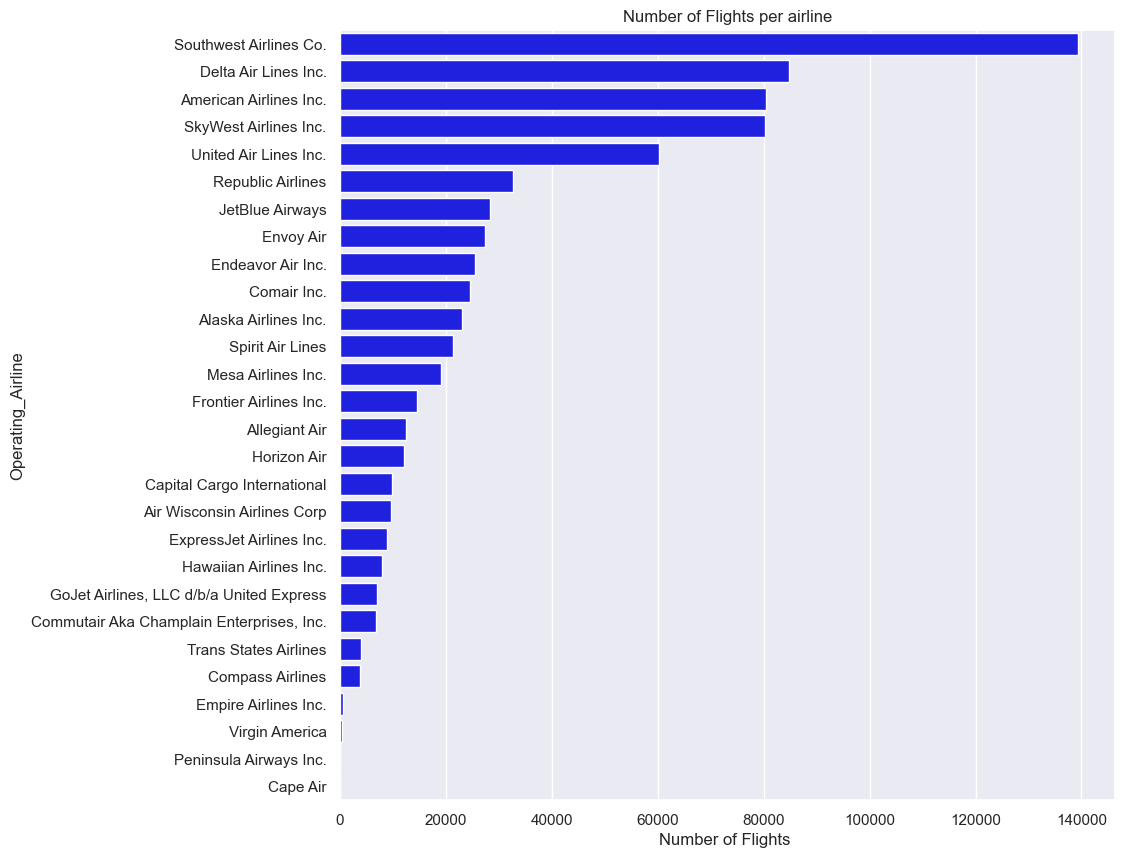

In [14]:
fig,ax = plt.subplots(figsize=(10,10))
sorted_airlines = df_flights["Operating_Airline"].value_counts().index.tolist()
sns.countplot(y=df_flights["Operating_Airline"], order=sorted_airlines, color='blue')
ax.set_title("Number of Flights per airline")
ax.set_xlabel("Number of Flights ")

In [15]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays"
              )
fig.show()


In [16]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["DepDelayMinutes"]]
              .mean(),
              title="Distribution of flight delays by airline"
              )
fig.show()

In [17]:
fig = px.line(df_flights
              .groupby("FlightDate")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations"
              )
fig.show()

In [18]:
fig = px.bar(df_flights
              .groupby("Operating_Airline")
              [["Cancelled"]]
              .mean(),
              title="Distribution of flight cancellations by airline",
              height=700
              )
fig.show()

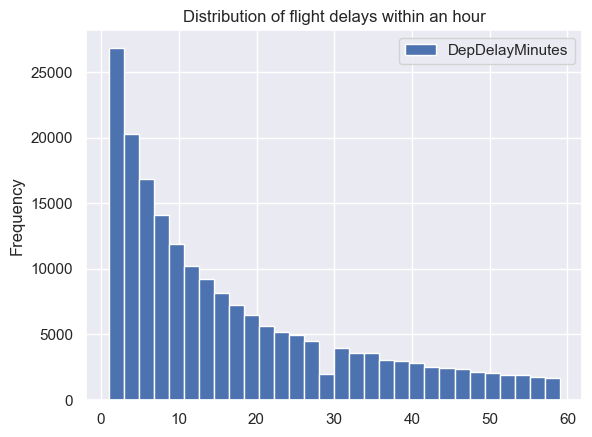

In [19]:
(df_flights
 .query("DepDelayMinutes > 0 and DepDelayMinutes < 60")
 [["DepDelayMinutes"]]
 .plot(kind="hist", bins=30, title="Distribution of flight delays within an hour"))
plt.show()


In [20]:
df_flights_2.head()

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,DestAirportID,CRSDepTime,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,Cancelled,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude,DepDelayClass
0,2018-01-02,Endeavor Air Inc.,N8969A,3298,13422,10397,914,913.0,0.0,20.0,1120.0,11.0,1130,0.0,76.0,47.0,302.0,0.0,30.68750,-88.2500,OnTime
1,2018-01-12,Endeavor Air Inc.,N8928A,3299,10397,11612,939,0.0,0.0,0.0,0.0,0.0,1008,1.0,89.0,0.0,350.0,0.0,33.62500,-84.4375,Cancelled
2,2018-01-02,Endeavor Air Inc.,N300PQ,3300,11193,10721,910,1041.0,91.0,15.0,1237.0,10.0,1119,0.0,129.0,101.0,752.0,0.0,39.03125,-84.6875,Delay45_180
3,2018-01-09,Endeavor Air Inc.,N8970D,3301,10397,11617,1225,1246.0,21.0,16.0,1403.0,2.0,1350,0.0,85.0,61.0,433.0,0.0,33.62500,-84.4375,Delay15_45
4,2018-01-06,Endeavor Air Inc.,N601LR,3303,14492,10721,1420,1418.0,0.0,10.0,1551.0,7.0,1618,0.0,118.0,83.0,612.0,0.0,35.87500,-78.8125,OnTime


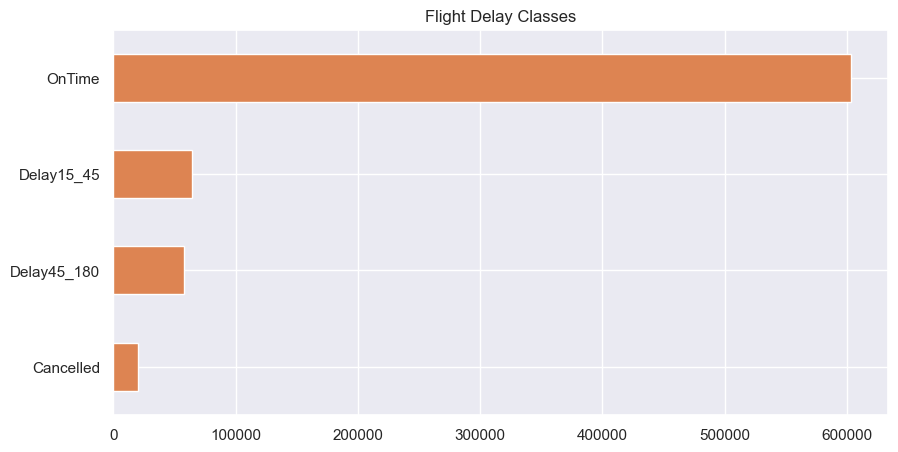

In [21]:
(df_flights
 .DepDelayClass
 .value_counts(ascending=True)
 .plot(kind='barh', figsize=(10,5), color=current_palette[1], title="Flight Delay Classes")
 )
plt.show()

Percentage of flights per year 

In [22]:
df_flights["Year"] = df_flights["FlightDate"].dt.year
df_flights_agg = df_flights.groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.534901,9.545650,8.286496,80.632953
2019,1.920910,9.018443,8.792105,80.268542
2020,6.033322,4.557261,3.782804,85.626613
2021,1.698761,8.953289,7.500477,81.847474
2022,2.960209,10.895310,9.682067,76.462413


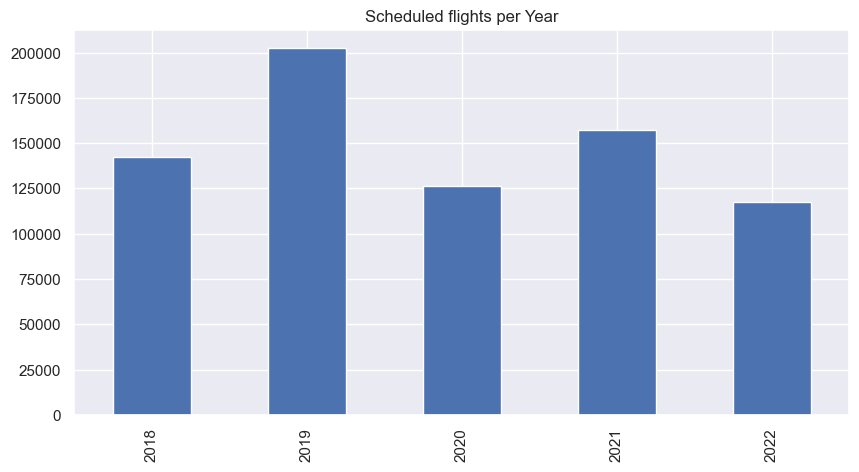

In [23]:
df_flights["Year"].value_counts().sort_index().plot(kind="bar", figsize=(10,5), title="Scheduled flights per Year")
plt.show()

In [24]:
px.bar(
    df_flights["Year"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='v',
    template="plotly_dark",
    title="Scheduled flights per year",
    height=700,
)

Percentage of Flights by Month

In [25]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,2.915539,7.805016,7.174308,82.105138
2,3.147596,8.786539,7.789315,80.276550
3,5.643986,7.587232,6.296974,80.471809
4,6.789110,7.888254,6.817536,78.505101
5,1.970518,8.983395,7.943070,81.103016
6,1.838697,10.721602,10.604308,76.835393
7,1.740396,10.097860,9.888478,78.273266
8,2.217818,9.566346,9.414211,78.801625
9,1.436010,6.689970,5.938632,85.935389


- Why the high cancellations in March - April?
- Lets analyse per year for these months 

In [26]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("3 <= Month <= 4").groupby("Year")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Year,,,,
2018,1.533624,9.791969,7.334301,81.340106
2019,2.061398,8.269254,8.029694,81.639655
2020,24.907063,3.458024,2.757125,68.877788
2021,0.860542,5.758036,4.117101,89.264321
2022,2.044648,11.015156,9.574686,77.365511


The analysis shows that the majority of cancellations happened in 2020 March -April 2020, which was when we had covid-19

- How about the situation without 2020?

In [27]:
df_flights["Month"] = df_flights["FlightDate"].dt.month
df_flights_agg = df_flights.query("Year != 2020").groupby("Month")["DepDelayClass"].value_counts(normalize=True).unstack()*100
df_flights_agg.style.background_gradient(cmap="YlGnBu")

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Month,,,,
1,3.411737,7.960062,7.496350,81.131852
2,3.950080,9.466610,8.141332,78.441978
3,1.814163,8.672536,7.258556,82.254745
4,1.572499,8.836896,7.640707,81.949898
5,1.513364,9.555760,8.486636,80.444240
6,2.006646,11.523986,11.485432,74.983936
7,1.894363,11.082026,10.933921,76.089689
8,2.400637,10.523495,10.502380,76.573489
9,1.557892,7.347096,6.590589,84.504424


  Observations
  - Without the year 2020 when covid-19 was at its peak, we see that most cancellations happened in the months of January and February, this would be due to the weather
    - Winter: December, January, February
    - Spring: March, April, May
    - Summer: June, July, August
    - Autumn: September, October, November

Lets group by Month and Year analyse the cancellations

In [28]:
df_flights_agg = df_flights.query("Cancelled > 0").groupby(["Month", "Year"]).size().unstack()
df_flights_agg.style.background_gradient(cmap="YlGnBu")

Year,2018,2019,2020,2021,2022
Month,,,,,
1,306.000000,467.000000,231.000000,92.000000,864.000000
2,139.000000,449.000000,150.000000,495.000000,604.000000
3,228.000000,313.000000,2998.000000,146.000000,265.000000
4,89.000000,384.000000,3434.000000,58.000000,334.000000
5,107.000000,351.000000,342.000000,58.000000,305.000000
6,106.000000,380.000000,20.000000,182.000000,425.000000
7,158.000000,385.000000,72.000000,272.000000,285.000000
8,280.000000,342.000000,111.000000,466.000000,390.000000
9,231.000000,306.000000,68.000000,192.000000,nan


(<Figure size 2000x1000 with 5 Axes>,
 array([<AxesSubplot: ylabel='2018'>, <AxesSubplot: ylabel='2019'>,
        <AxesSubplot: ylabel='2020'>, <AxesSubplot: ylabel='2021'>,
        <AxesSubplot: ylabel='2022'>], dtype=object))

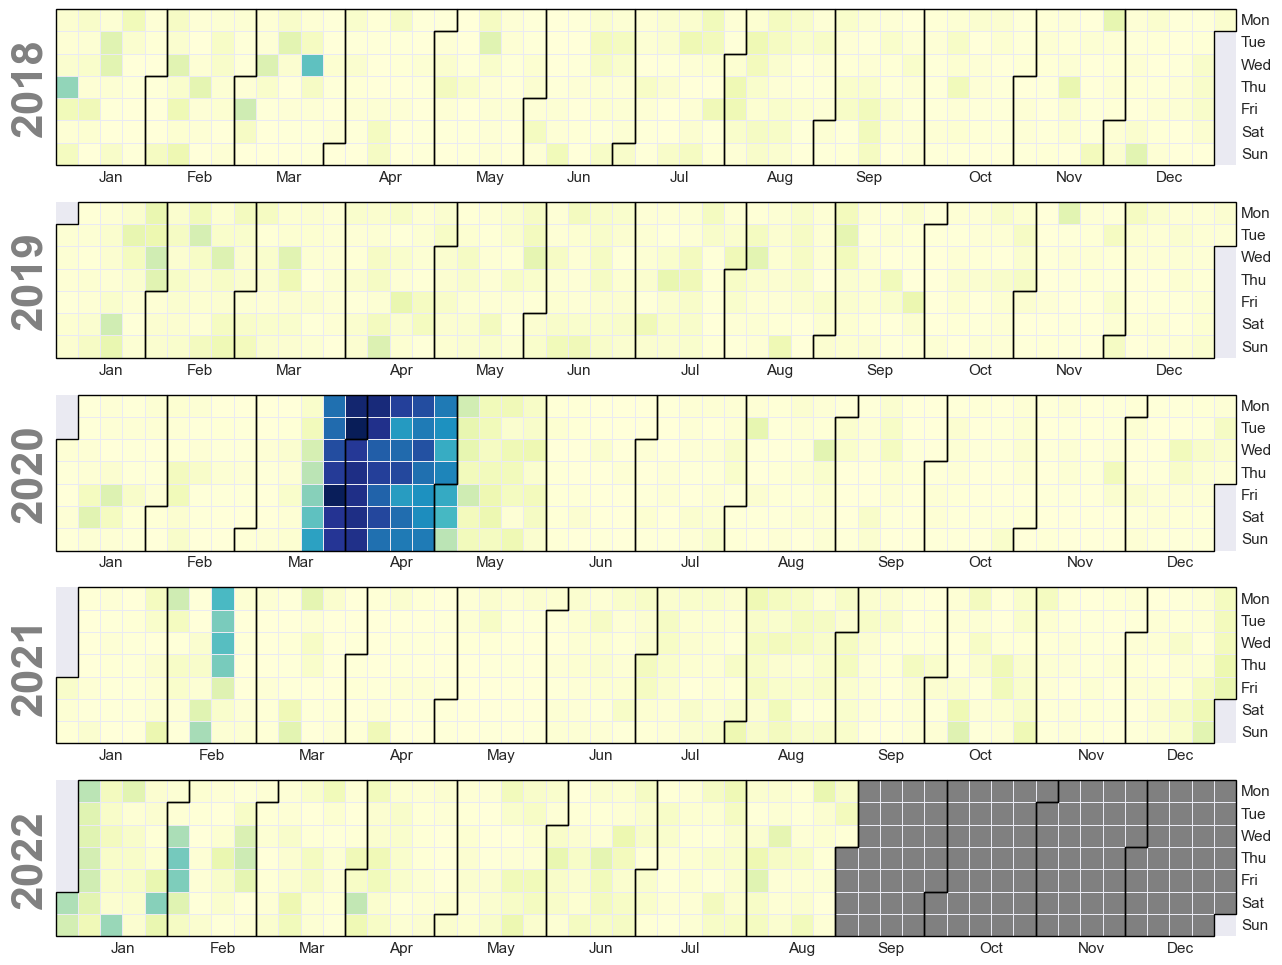

In [29]:
events = df_flights.groupby("FlightDate")["Cancelled"].mean()
calmap.calendarplot(events, monthticks=3, daylabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                    dayticks=True, cmap='YlGnBu',
                    fillcolor='grey', linewidth=0.5, monthly_border=True, 
                    fig_kws=dict(figsize=(20, 10)))

In [30]:
fig = calplot(
         events.reset_index(),
         x="FlightDate",
         y="Cancelled",
         colorscale="Reds",
         years_title=True
)
fig.show()

In [31]:
df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()

DepDelayClass,Cancelled,Delay15_45,Delay45_180,OnTime
Operating_Airline,,,,
Air Wisconsin Airlines Corp,0.038136,0.054122,0.095079,0.812663
Alaska Airlines Inc.,0.016456,0.083279,0.051756,0.848509
Allegiant Air,0.047566,0.107944,0.099936,0.744555
American Airlines Inc.,0.030787,0.086632,0.083053,0.799528
Cape Air,0.000000,0.000000,0.024390,0.975610
Capital Cargo International,0.038652,0.057169,0.068097,0.836082
Comair Inc.,0.033560,0.076679,0.080666,0.809096
"Commutair Aka Champlain Enterprises, Inc.",0.044244,0.088636,0.130660,0.736460
Compass Airlines,0.011799,0.076560,0.079706,0.831935


<AxesSubplot: ylabel='Operating_Airline'>

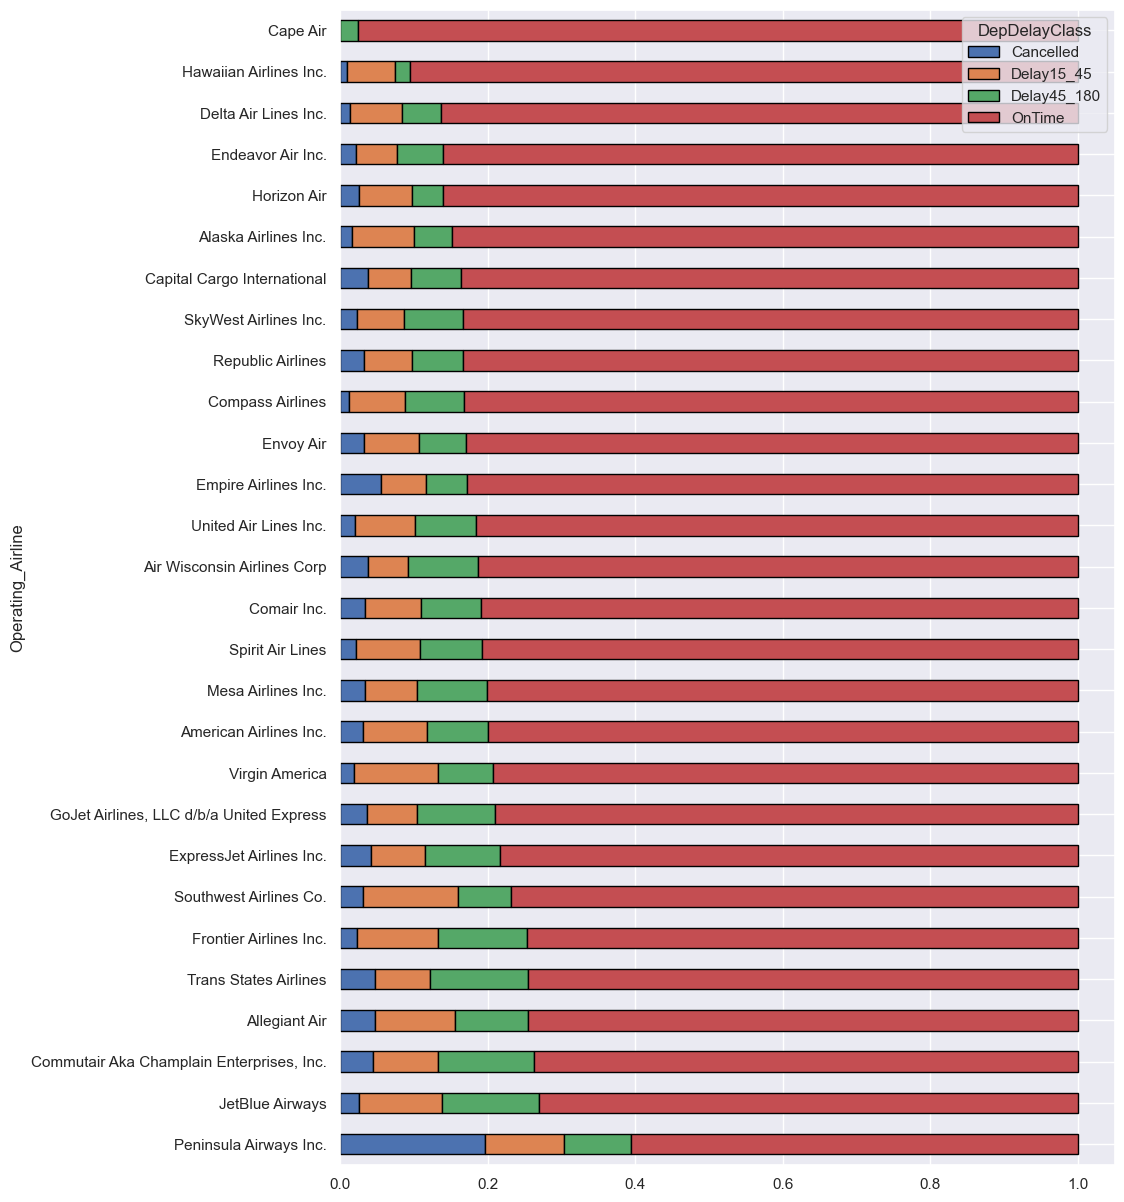

In [32]:
stacked_df_flights = df_flights.groupby(["Operating_Airline"])[["DepDelayClass"]].value_counts(normalize=True).unstack()
stacked_df_flights.sort_values("OnTime").plot(kind='barh', figsize=(10,15), stacked=True, edgecolor="black")

In [33]:
fig = px.bar(stacked_df_flights.sort_values("OnTime"), barmode='stack', height=700, orientation='h')
fig.show()


#### Correlation [Pearson]

In [34]:
corr = (df_flights_2
        .select_dtypes('float16')
        .corr())
corr.style.background_gradient(cmap='coolwarm')


,DepTime,DepDelayMinutes,TaxiOut,WheelsOn,TaxiIn,CRSElapsedTime,AirTime,Distance,TotalAddGTime,latitude,longitude
DepTime,1.000000,0.122631,0.116546,0.731370,0.044170,-0.014392,0.077451,-0.006491,0.020631,-0.035919,-0.005621
DepDelayMinutes,0.122631,1.000000,0.064087,0.038910,0.026809,0.014789,0.018566,0.011361,0.210594,-0.002710,0.025049
TaxiOut,0.116546,0.064087,1.000000,0.136053,0.075792,0.068934,0.103976,0.030503,0.017226,0.080058,0.102923
WheelsOn,0.731370,0.038910,0.136053,1.000000,0.076241,0.025077,0.122154,0.025761,-0.017171,-0.017726,-0.004225
TaxiIn,0.044170,0.026809,0.075792,0.076241,1.000000,0.097810,0.118077,0.067008,-0.000326,0.000232,0.050340
CRSElapsedTime,-0.014392,0.014789,0.068934,0.025077,0.097810,1.000000,0.946655,0.981695,0.006234,-0.040842,-0.032632
AirTime,0.077451,0.018566,0.103976,0.122154,0.118077,0.946655,1.000000,0.943668,-0.006894,-0.056451,-0.063316
Distance,-0.006491,0.011361,0.030503,0.025761,0.067008,0.981695,0.943668,1.000000,0.002218,-0.075607,-0.126070
TotalAddGTime,0.020631,0.210594,0.017226,-0.017171,-0.000326,0.006234,-0.006894,0.002218,1.000000,0.004981,0.018505
latitude,-0.035919,-0.002710,0.080058,-0.017726,0.000232,-0.040842,-0.056451,-0.075607,0.004981,1.000000,0.011596


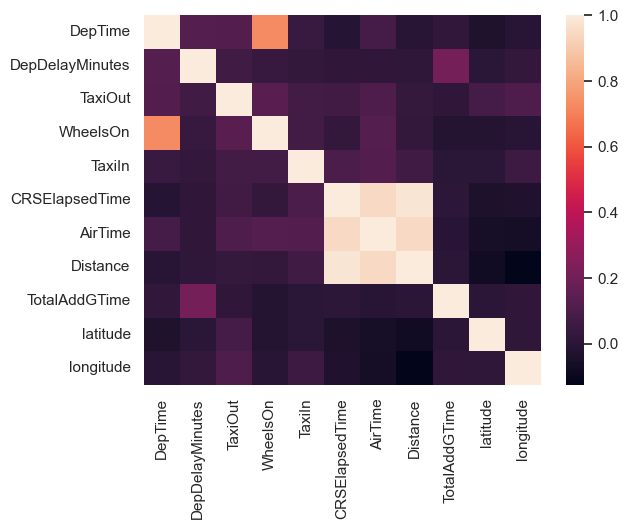

In [35]:
sns.heatmap(
    (df_flights_2
     .select_dtypes('float16')
     .corr()))
plt.show()


In [36]:
# Factors affecting delay
# Assumption: A flight is counted as "on time" if it operated less than 15 minutes later than the
def flight_status(df_flights):
        df_flights["FlightStatus"]="OnTime"

        df_flights.loc[df_flights["DepDel15"] == 0, "FlightStatus"]="OnTime"
        df_flights.loc[(df_flights["DepDelayMinutes"] >= 0) & (df_flights["DepDelayMinutes"] <= 15), "FlightStatus"]="OnTime"
        df_flights.loc[df_flights["WeatherDelay"] > 15, "FlightStatus"]="WeatherDelay"
        df_flights.loc[df_flights["NASDelay"] > 15, "FlightStatus"]="NASDelay"
        df_flights.loc[df_flights["SecurityDelay"] > 15, "FlightStatus"]="SecurityDelay"
        df_flights.loc[df_flights["LateAircraftDelay"] > 15, "FlightStatus"]="LateAircraftDelay"
        df_flights.loc[df_flights["CarrierDelay"] > 15, "FlightStatus"]="CarrierDelay"
        df_flights.loc[df_flights["Cancelled"], "FlightStatus"]="Cancelled"
    

flight_status(df_flights)

<AxesSubplot: xlabel='FlightDate'>

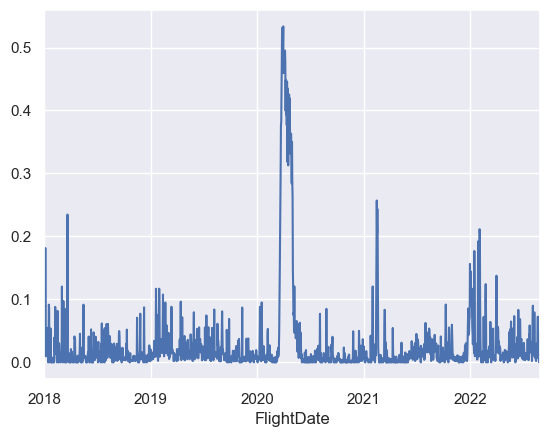

In [37]:
(df_flights.
 groupby("FlightDate")
 ["Cancelled"]
 .agg("mean")
 .plot()
 )


<AxesSubplot: xlabel='FlightDate'>

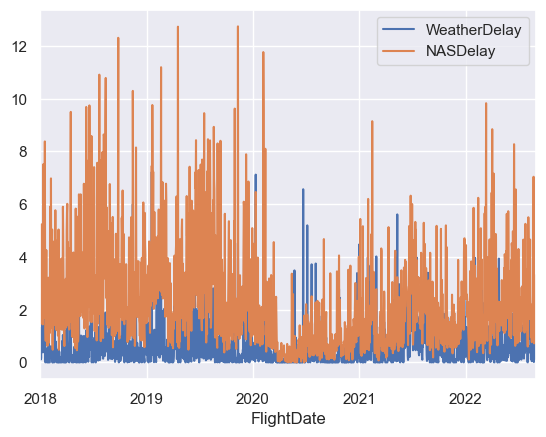

In [38]:
(df_flights.
 groupby("FlightDate")
 [["WeatherDelay", "NASDelay"]]
 .agg("mean")
 .plot())


<AxesSubplot: xlabel='FlightDate'>

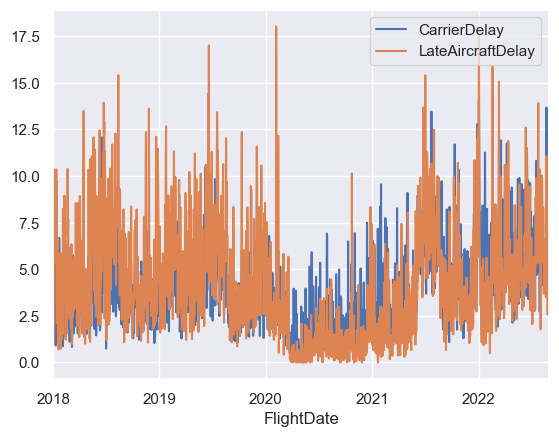

In [39]:
(df_flights.
 groupby("FlightDate")
 [["CarrierDelay", "LateAircraftDelay"]]
 .agg("mean")
 .plot())


##### Frequency Distribution Table

In [40]:
(df_flights
 [["Operating_Airline"]]
 .value_counts()
 .sort_values(ascending=False)
 .to_frame("Row Count")
 )


,Row Count
Operating_Airline,
Southwest Airlines Co.,139352
Delta Air Lines Inc.,84754
American Airlines Inc.,80455
SkyWest Airlines Inc.,80344
United Air Lines Inc.,60240
Republic Airlines,32678
JetBlue Airways,28291
Envoy Air,27487
Endeavor Air Inc.,25579


In [41]:
px.bar(
    df_flights["Operating_Airline"]
    .value_counts()
    .sort_values(ascending=True),
    orientation='h',
    template="plotly_dark",
    title="Flights per airline",
    height=700,
)


In [42]:
df_flights.head(3)

,FlightDate,Operating_Airline,Tail_Number,Flight_Number,OriginAirportID,Origin,OriginCityName,OriginState,OriginStateName,DestAirportID,Dest,DestCityName,DestState,DestStateName,CRSDepTime,DepTime,DepDelay,DepDel15,DepDelayMinutes,DepTimeBlk,TaxiOut,WheelsOn,TaxiIn,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrTimeBlk,Cancelled,CancellationCode,Diverted,CRSElapsedTime,AirTime,Distance,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,TotalAddGTime,latitude,longitude,DepDelayClass,DepDelayClass_ordinal,Year,Month,FlightStatus
0,2018-01-02,Endeavor Air Inc.,N8969A,3298,13422,MOB,"Mobile, AL",AL,Alabama,10397,ATL,"Atlanta, GA",GA,Georgia,914,913.0,-1.0,0.0,0.0,0900-0959,20.0,1120.0,11.0,1130,1131.0,1.0,0.0,1100-1159,0.0,none,False,76.0,47.0,302.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.68750,-88.2500,OnTime,1,2018,1,Cancelled
1,2018-01-12,Endeavor Air Inc.,N8928A,3299,10397,ATL,"Atlanta, GA",GA,Georgia,11612,EVV,"Evansville, IN",IN,Indiana,939,0.0,0.0,0.0,0.0,0900-0959,0.0,0.0,0.0,1008,0.0,0.0,0.0,1000-1059,1.0,National Air System,False,89.0,0.0,350.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33.62500,-84.4375,Cancelled,4,2018,1,Cancelled
2,2018-01-02,Endeavor Air Inc.,N300PQ,3300,11193,CVG,"Cincinnati, OH",KY,Kentucky,10721,BOS,"Boston, MA",MA,Massachusetts,910,1041.0,91.0,1.0,91.0,0900-0959,15.0,1237.0,10.0,1119,1247.0,88.0,1.0,1100-1159,0.0,none,False,129.0,101.0,752.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,39.03125,-84.6875,Delay45_180,3,2018,1,CarrierDelay


In [43]:
cols = ["FlightDate","Tail_Number","Flight_Number","Operating_Airline", "OriginCityName","DestCityName", "CRSDepTime", "DepTime","DepDelayMinutes","AirTime", "FlightStatus"]
(df_flights
 .loc[df_flights["DepDelayMinutes"] >10, cols ]
 .sort_values(by=["Flight_Number", "FlightDate", "CRSDepTime"],ascending=[True, True, True])
 .head())

,FlightDate,Tail_Number,Flight_Number,Operating_Airline,OriginCityName,DestCityName,CRSDepTime,DepTime,DepDelayMinutes,AirTime,FlightStatus
8417,2018-01-19,N954JB,1,JetBlue Airways,"New York, NY","Fort Lauderdale, FL",1000,1011.0,11.0,146.0,OnTime
141681,2018-12-09,N388HA,1,Hawaiian Airlines Inc.,"Los Angeles, CA","Honolulu, HI",700,719.0,19.0,334.0,OnTime
128703,2018-12-27,N8566Z,1,Southwest Airlines Co.,"Nashville, TN","Baltimore, MD",1140,1201.0,21.0,78.0,LateAircraftDelay
137730,2018-12-28,N8581Z,1,Southwest Airlines Co.,"Houston, TX","Nashville, TN",855,924.0,29.0,76.0,OnTime
173469,2019-03-30,N103NN,1,American Airlines Inc.,"New York, NY","Los Angeles, CA",800,950.0,110.0,357.0,CarrierDelay
